# Regularization parameters :

The objective of this notebook is to introduce some of the regularization parameter.
Using the example of autoencoders we will present the l1 regularization and the dropout.

# Autoencoders :

The general idea of an autoencoder is given an input X, build a representation of X (encoding phase) and using this representation reconstruct X (decoding).
It's a two phase process that has applications in compression, dimensionnality reduction, outlierness detection and generative models.



In [1]:
# Import the initial package 
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn
import gc
from sklearn.preprocessing import LabelEncoder
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")
import time

ModuleNotFoundError: No module named 'pandas'

In [2]:
# read datasets ( same at notebook 5)
pathData = ''

train = pd.read_csv(pathData+'trainDataset.csv')
Y = train['target'].as_matrix()
DF_X = train.drop('target',axis=1)

test =  pd.read_csv(pathData+'testDataset.csv')
Y_test = test['target'].as_matrix()
DF_X_test = test.drop('target',axis=1)

# right type
for c in DF_X.columns:
    if 'Cat_' in c:
        DF_X[c] = DF_X[c].astype(str)
        DF_X_test[c] = DF_X_test[c].astype(str)
    else:
        DF_X[c] = DF_X[c].astype(float)
        DF_X_test[c] = DF_X_test[c].astype(float)

# Categorization
treshold_ExLR = 0.75

Id_0_train = np.nonzero(Y<treshold_ExLR)[0]
Id_0_test = np.nonzero(Y_test<treshold_ExLR)[0]

Id_1_train = np.nonzero(Y>=treshold_ExLR)[0]
Id_1_test = np.nonzero(Y_test>=treshold_ExLR)[0]

Y[Id_0_train] = 0
Y[Id_1_train] = 1

Y_test[Id_0_test] = 0
Y_test[Id_1_test] = 1


# Encode categorical variables
DF_X = DF_X.copy()
DF_X_test = DF_X_test.copy()
for var in DF_X.columns:
    if str(DF_X[var].dtypes)=='object':
        le = LabelEncoder().fit(DF_X[var])
        DF_X[var] = le.transform(DF_X[var])
        DF_X_test[var] = le.transform(DF_X_test[var])
        


In [3]:
# Normalization (same as TD 5)
from sklearn.preprocessing import MinMaxScaler

normX = MinMaxScaler()
X_train=DF_X.as_matrix()
X_test=DF_X_test.as_matrix()

# We fit the normalization on the train sample
normX.fit(X_train)
# This normalization is then applied both to the train set and the test set. 
X_train_norm = normX.transform(X_train)
X_test_norm=normX.transform(X_test)

print('Train shape :',X_train_norm.shape)
print('Test shape :',X_test_norm.shape)

('Train shape :', (35572L, 47L))
('Test shape :', (8893L, 47L))


---------------------------------------------------

## KERAS Modelling

In [4]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD

Using Theano backend.
WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.


# First autoencoder 

Given the data, let us build a first autoencoder model.
Given an input X of dimension d, let us build an autoencoder with three layers.
The input layer of dimension d, one dense hidden layer with linear activation dimension d and the output layer of dimension d with a linear activation function.

Can you think of an optimal solution that reconstructs X perfectly ? 
(Very very simple)

In [6]:
model = Sequential()

# Là on peut mettre pleins de trous. 
dimension_input=X_train_norm.shape[1]
layer_dim=X_train_norm.shape[1]
dimension_output=X_train_norm.shape[1]


input_ae=X_train_norm
output_ae=X_train_norm

# Input layer with N_Neurons=Cols(X)
model.add(Dense(layer_dim,input_dim=dimension_input,\
                kernel_initializer='normal',\
                activation='linear'))

# Output layer with N_Neurons=Cols(X)
model.add(Dense(dimension_output, kernel_initializer='normal',\
                activation='linear'))

# Compile with adam optimizer 
model.compile(loss='mse',\
              optimizer='adam')

model.fit(input_ae,output_ae,epochs=10,batch_size=128,verbose=1)

Epoch 1/10
35572/35572 [==============================] - 111s - loss: 0.0241   
Epoch 2/10
35572/35572 [==============================] - 91s - loss: 0.0061    
Epoch 3/10
35572/35572 [==============================] - 81s - loss: 0.0029    
Epoch 4/10
35572/35572 [==============================] - 82s - loss: 0.0015    
Epoch 5/10
21120/35572 [================>.............] - ETA: 33s - loss: 9.5108e-04

KeyboardInterrupt: 

# Reconstruction error:

Let us compute the reconstruction accurary defined as R= 1-norm(X_reconstr-X_init)/norm(X_init)

In [17]:
def Compute_Reconstruction_error(model,X_querry):
    X_reconstr=model.predict(X_querry)
    Error=np.linalg.norm(X_reconstr-X_querry,axis=1)/np.linalg.norm(X_querry,axis=1)
    return Error


Error_train= Compute_Reconstruction_error(model,X_train_norm)
print('Accuracy train : ',100-100*np.median(Error_train),'%')

Error_test= Compute_Reconstruction_error(model,X_test_norm)
print('Accuracy test : ',100-100*np.median(Error_test),'%')



Accuracy train :  97.9070450929 %
Accuracy test :  97.8880355209 %


# Visualization of the layers :

Did we find the trivial solution? 
Write a function that will visualize the weights applied on the first layer on each of the node i.

Hints: 
use : 
- Use a for loop to iterate on each on the node of the first layer
- You can get the weights used on node i of the layer K with : model.layers[pos].get_weights()[0][:,i]

- Use plt.scatter to scatter the data


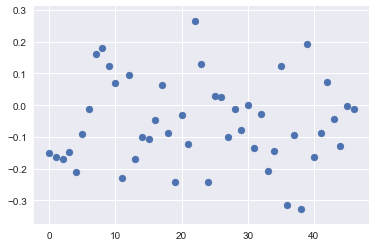

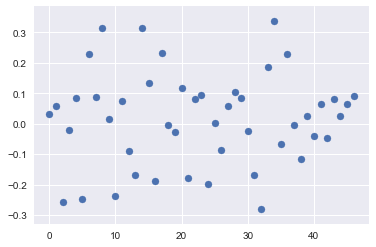

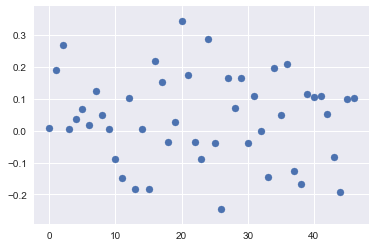

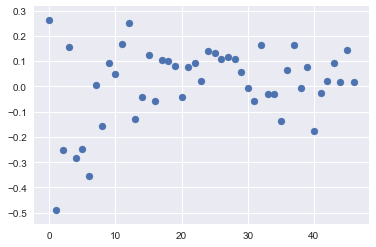

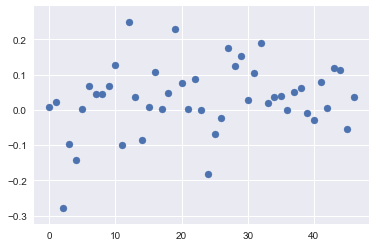

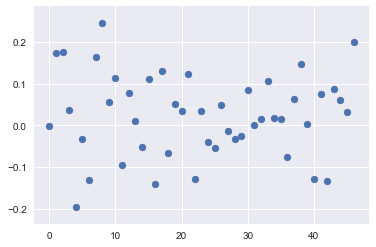

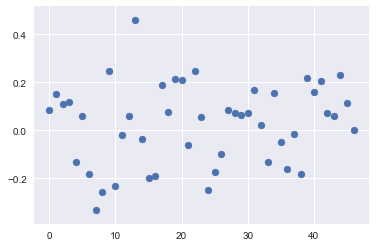

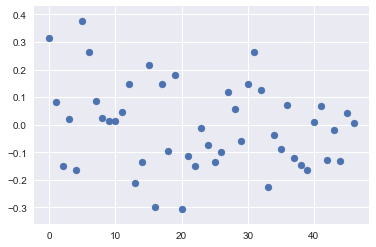

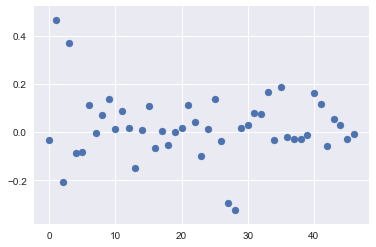

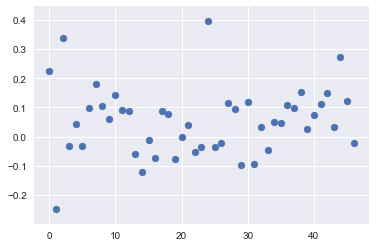

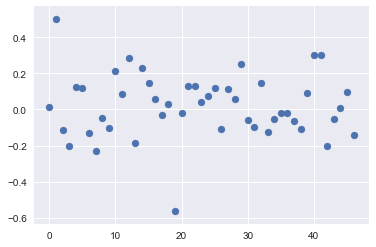

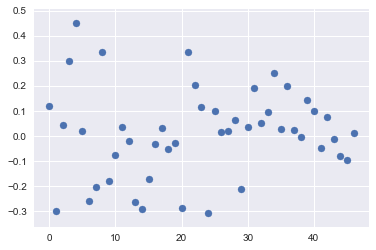

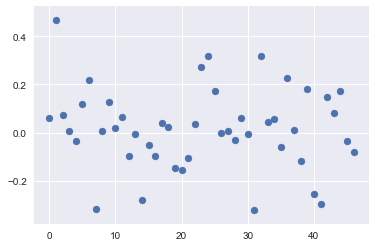

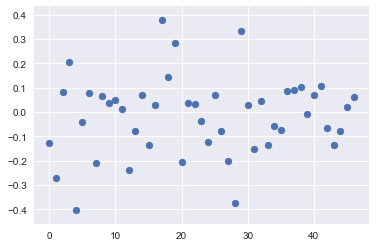

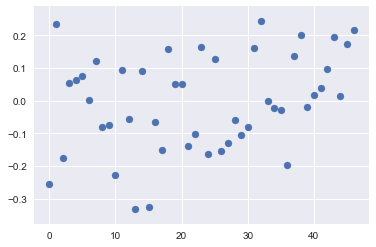

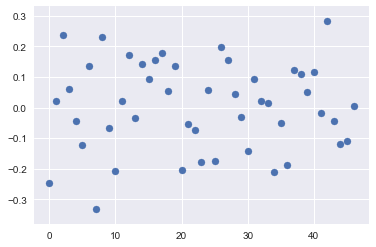

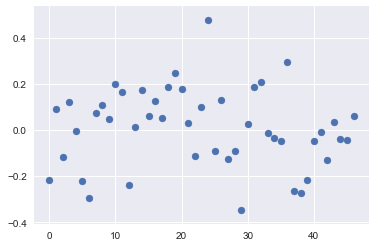

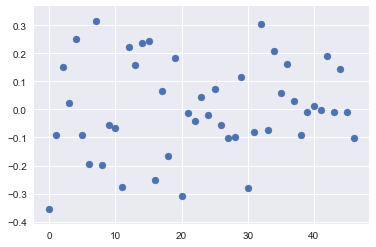

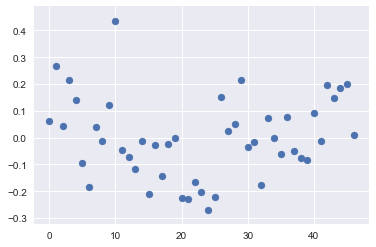

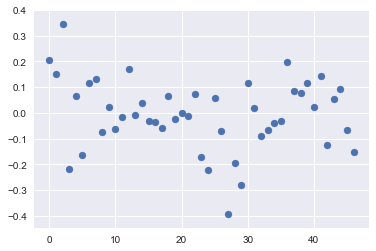

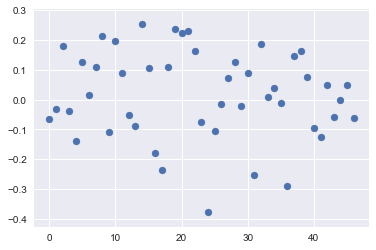

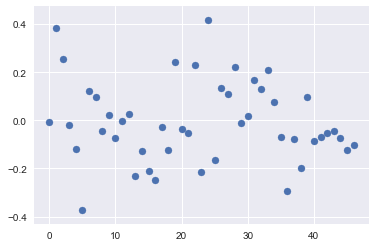

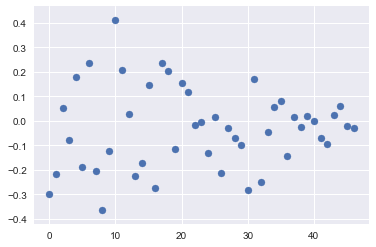

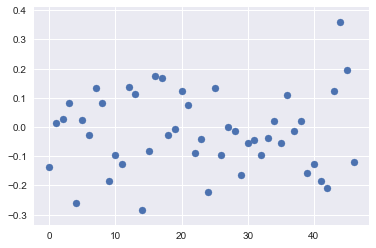

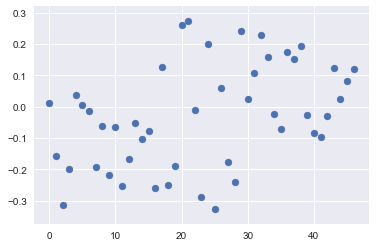

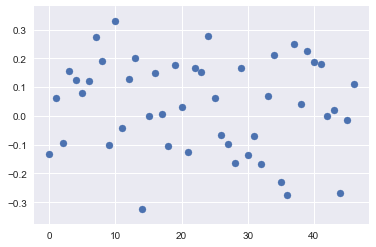

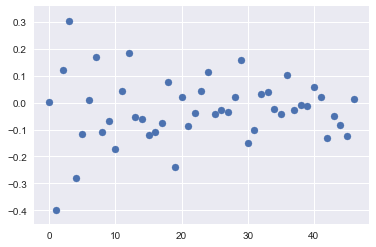

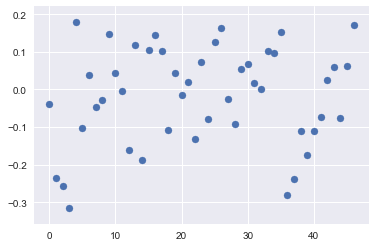

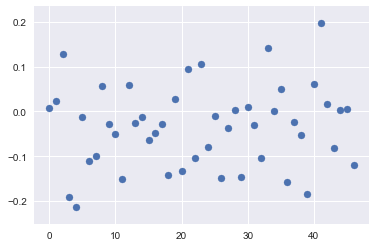

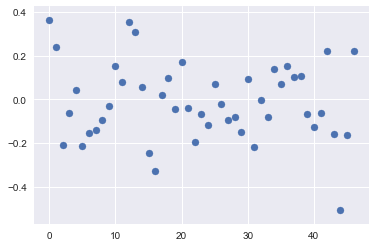

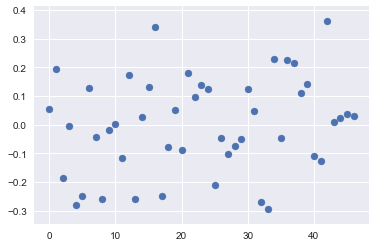

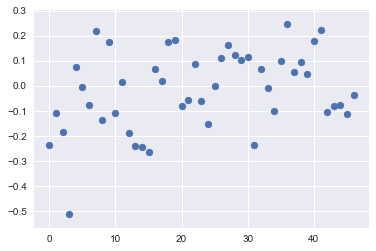

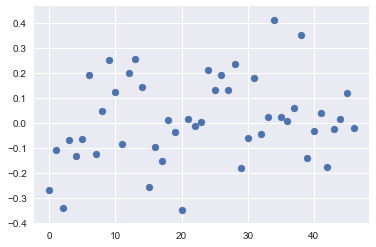

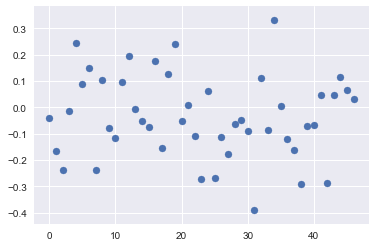

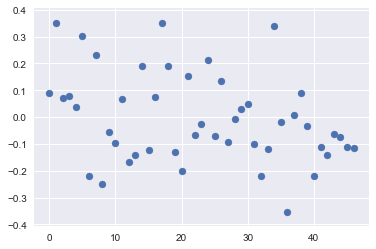

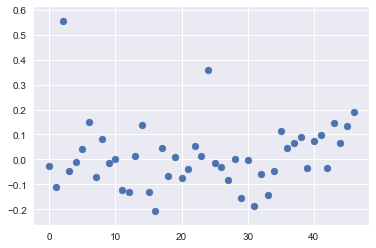

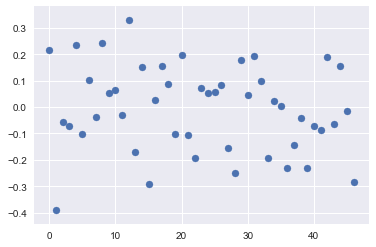

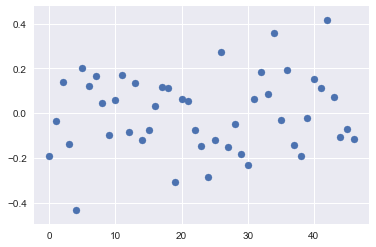

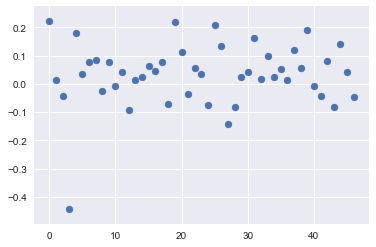

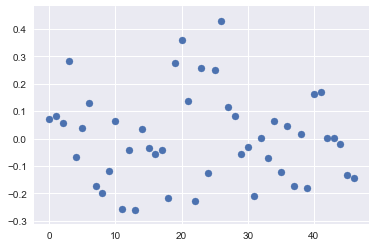

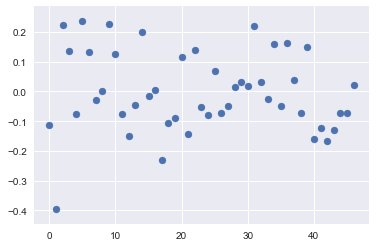

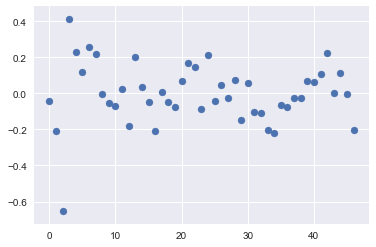

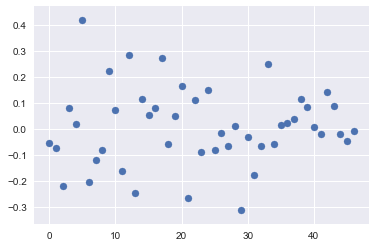

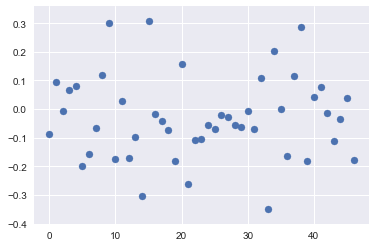

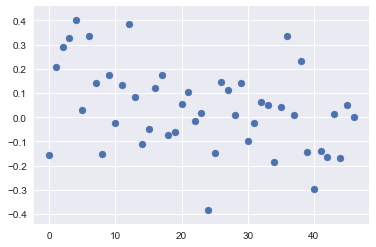

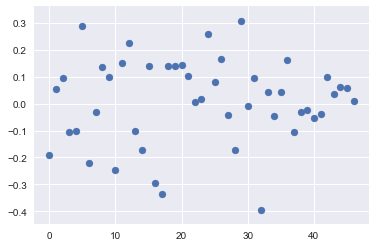

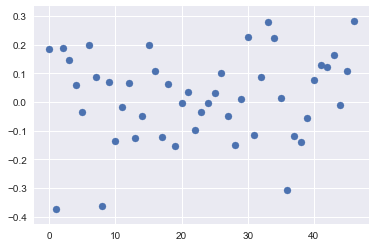

In [18]:
def Visualize_layer(model,layer_index):
    layer_dim=model.layers[layer_index].get_weights()[0].shape[1]
    for pos in range(layer_dim):
        plt.scatter(range(layer_dim),model.layers[layer_index].get_weights()[0][:,pos])
        plt.show()
        
Visualize_layer(model,0)

# Importance of regularization 

We did not get a simple and naive model because we did not impose any constraint on the model. 
To get a simpler model, we have to use regularization. 

There are two types of regularization that are commonly used in keras and available in the regularizers package:
    - regularizers.l1 
    - regularizers.l2
    
Those regularization add a loss that is a function of the norm of the weights of the layer.
The regularization need to be added at each layer and can be used with different parameters. 

Regularization are very important because:
- They create simpler models
- They avoid overfitting and can improve the overall perfomances (if well tuned).

The model has to find a trade off between the regularization and the overfitting.
If the regularization parameters are not well tuned the model will overfit or underfit.

Exercice :

Build the same network as before but add a l1 regularizer with the regularization parameter lambda= 0.000005 :
Increase the nb epochs ( regularized networks are longer to train)


In [19]:
from keras import regularizers

model = Sequential()

# Là on peut mettre pleins de trous. 
dimension_input=X_train_norm.shape[1]
layer_dim=X_train_norm.shape[1]
dimension_output=X_train_norm.shape[1]


input_ae=X_train_norm
output_ae=X_train_norm

# Input layer with N_Neurons=Cols(X)
model.add(Dense(layer_dim,input_dim=dimension_input,\
                kernel_initializer='normal',\
                activation='linear',kernel_regularizer=regularizers.l1(0.000005)))

# Output layer with N_Neurons = Cols(X)
model.add(Dense(dimension_output, kernel_initializer='normal',\
                activation='linear',kernel_regularizer=regularizers.l1(0.000005)))

# Compile model with stochastic gradient descent optimizer
model.compile(loss='mse',\
              optimizer='adam')

model.fit(input_ae,output_ae,epochs=50,batch_size=128,verbose=0)



# Visualization of the reconstruction error 2 and layers weight

In [20]:
Error_train= Compute_Reconstruction_error(model,X_train_norm)
print('Accuracy train : ',100-100*np.median(Error_train),"%")

Error_test= Compute_Reconstruction_error(model,X_test_norm)
print('Accuracy test : ',100-100*np.median(Error_test),"%")



Accuracy train :  98.7997817946 %
Accuracy test :  98.7892971125 %


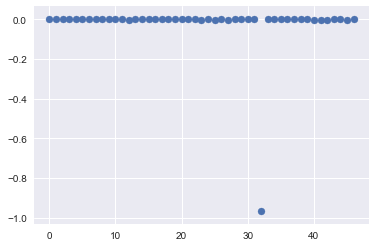

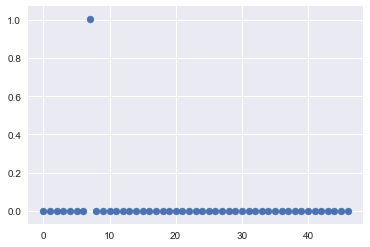

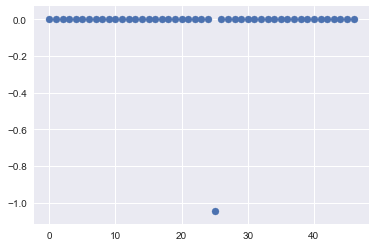

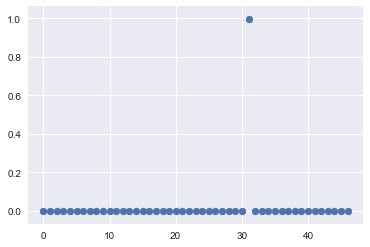

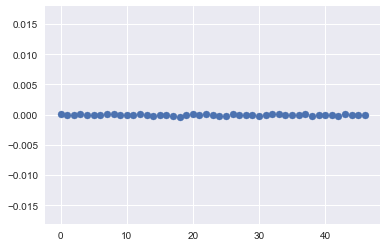

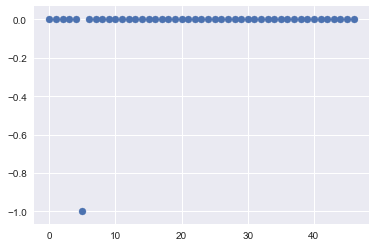

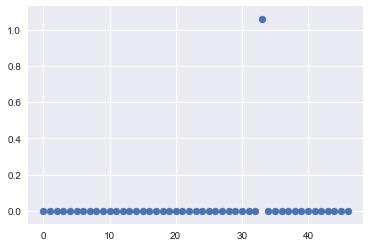

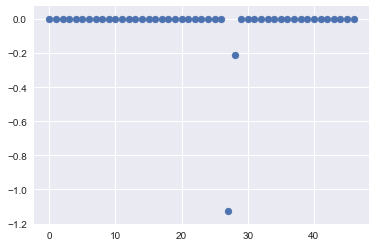

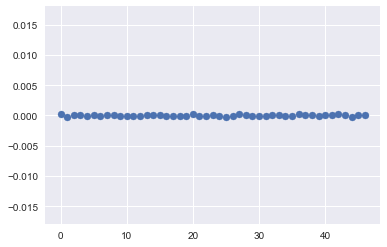

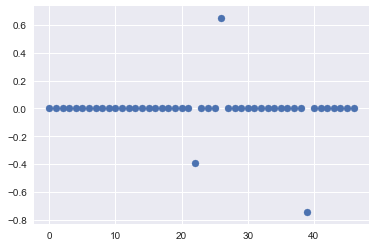

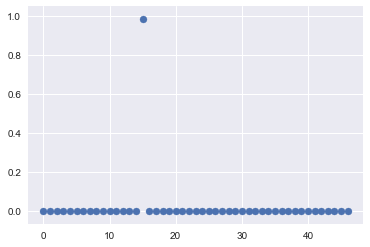

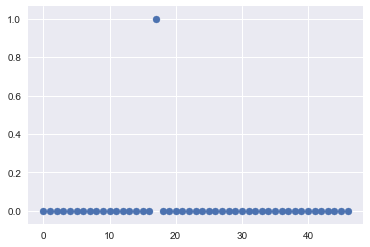

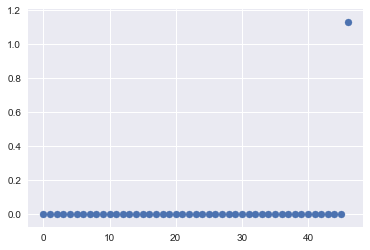

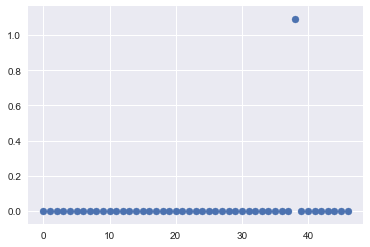

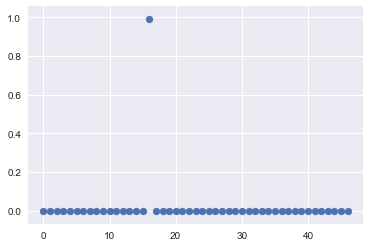

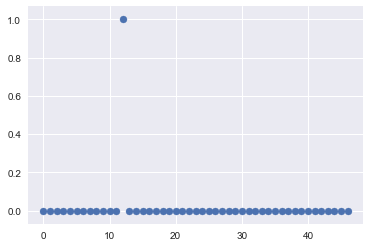

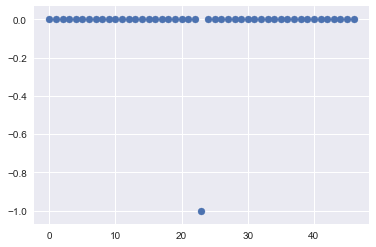

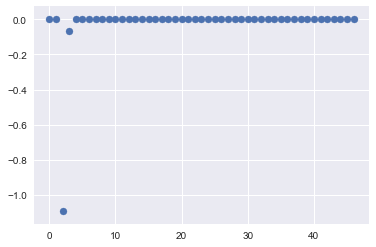

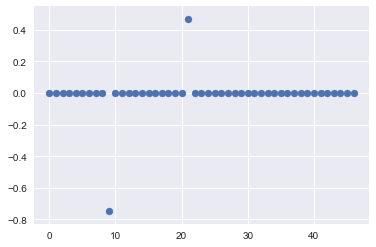

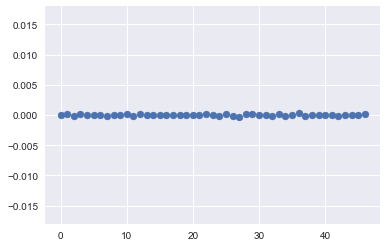

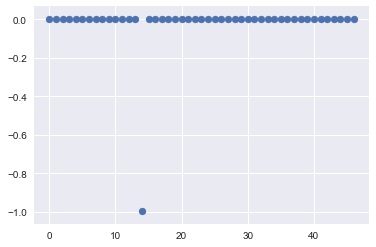

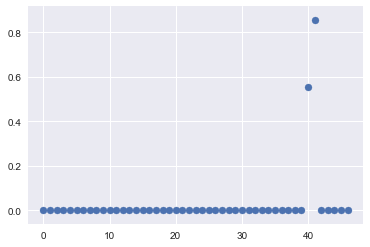

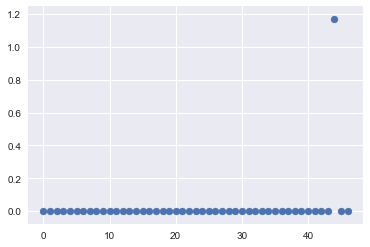

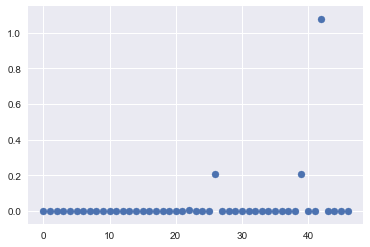

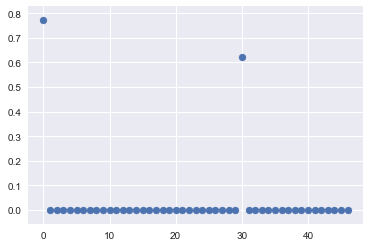

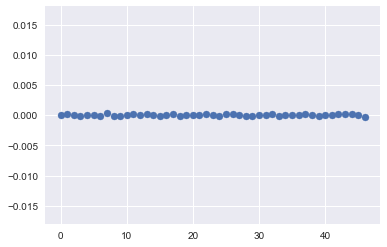

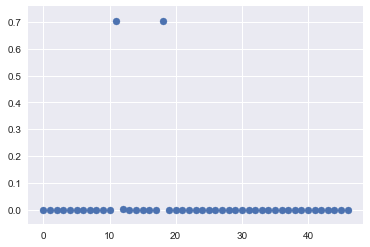

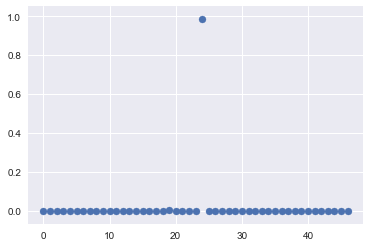

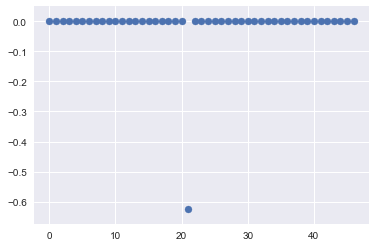

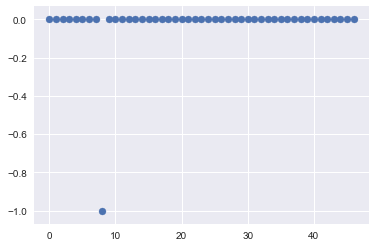

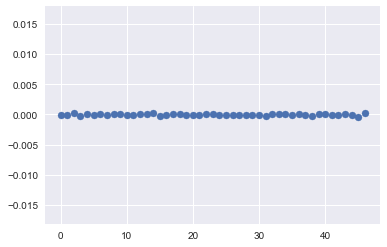

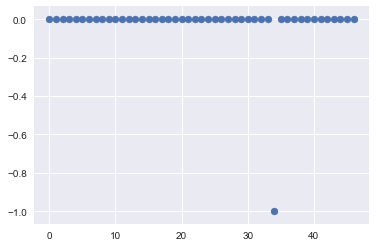

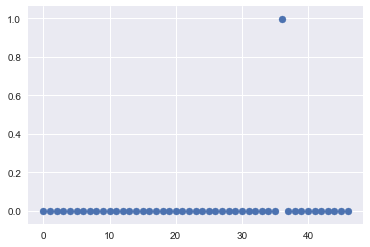

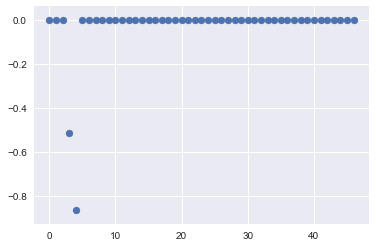

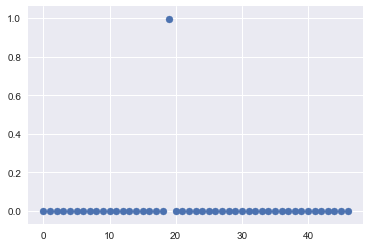

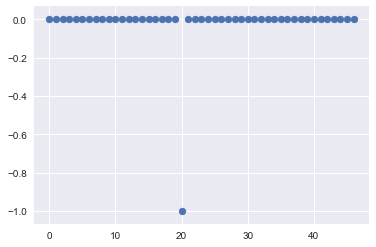

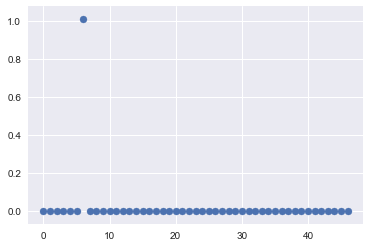

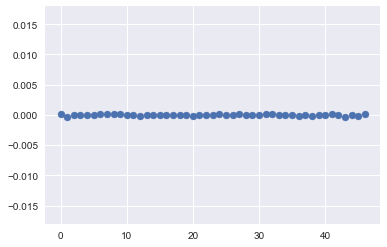

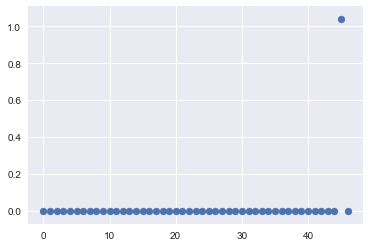

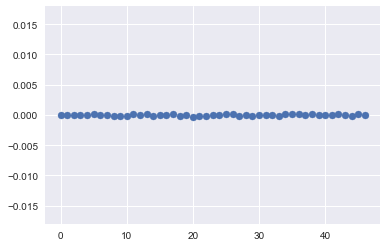

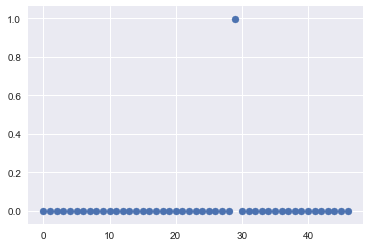

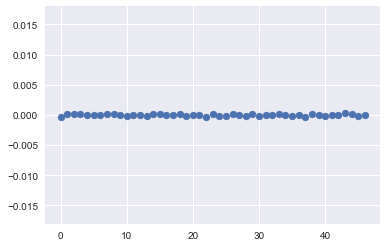

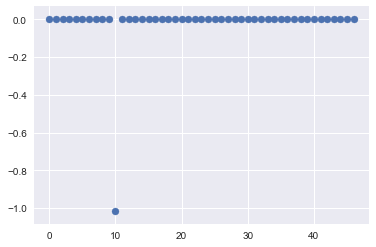

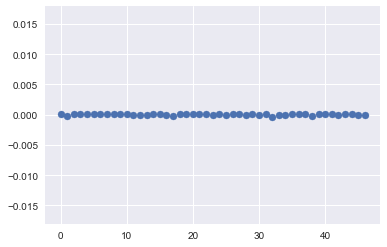

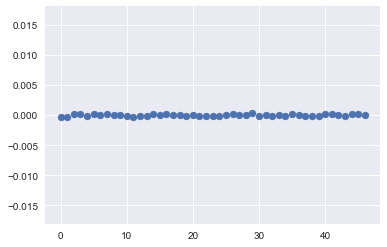

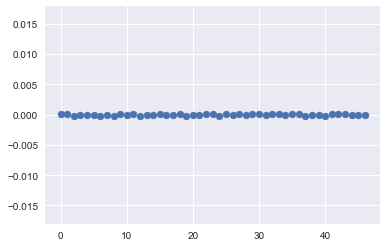

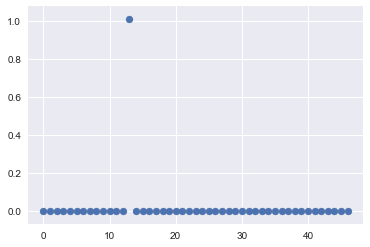

In [21]:
Visualize_layer(model,0)

The model we have created shoud be simpler and look like the trivial autoencoder we discussed earlier.

# Detecting outliers with autoencoders :


Basically, autoencoders regularize inputs and can therefore be used to denoise.
Another interesting use would nonetheless be to take advantage of the reconstruction error to try to detect outliers

Objective of this part : 
- Create outliers
- Find them with autoencoders 

In [23]:
# Let's first add noise to some of the elements of the test sample.
nb_of_elements_to_blur=1000


Initial_value=X_test_norm[-nb_of_elements_to_blur:,:]
Noise= np.random.random_sample(Initial_value.shape) # noise between 0 and 1

# We add the noise
alpha=0.7
X_test_norm[-nb_of_elements_to_blur:,:]=alpha*Initial_value+(1-alpha)*Noise


# Can we detect our outlier with the current autoencoder? 

- Look at the distribution of the errors of the autoencoder with the train and test and conclude
- Scatter the error for each of the sample 
- What do you see ? 

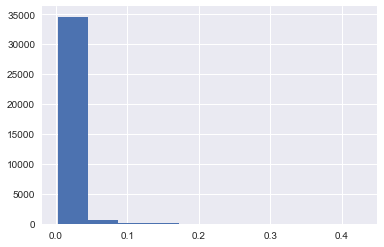

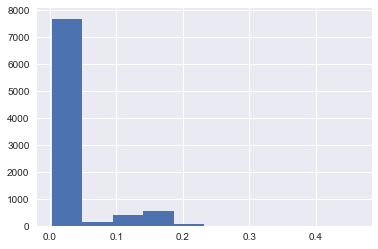

In [24]:
plt.hist(Compute_Reconstruction_error(model,X_train_norm))
plt.show()
plt.hist(Compute_Reconstruction_error(model,X_test_norm))
plt.show()

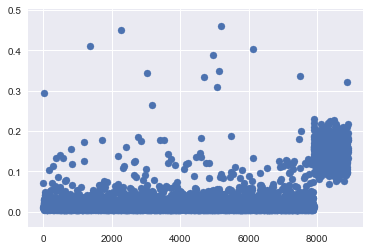

In [26]:
# This function will scatter the reconstruction error of the train (blue) and the test (red) sample

def Plot_model_error(Test_sample,model):
  
    Error_test=Compute_Reconstruction_error(model,Test_sample)
    plt.scatter(range(Test_sample.shape[0]),Error_test)
    plt.show()

Plot_model_error(X_test_norm,model)

# How can we improve the outlier detection ?  

- First Idea : Reduce the layer dimension 
- Second Idea: Increase the layer dimension

Hint : Play with layer_dim_parameter

In [27]:
from keras.layers import Dropout
#from keras.layers.noise import GaussianNoise

default_layer_dim=X_train_norm.shape[1]
default_reg=0.000005
default_dropout=0
def Build_generic_model(layer_dim_parameter=default_layer_dim,\
                        regularization_parameter=default_reg,\
                        first_dropout_parameter=default_dropout,second_dropout_parameter=default_dropout):
    model = Sequential()

    print("Current model: ")
    print("Layer dim : ",layer_dim_parameter)
    print("Regularization param : ",regularization_parameter)
    if first_dropout_parameter>0:
        print("First dropout param : ",first_dropout_parameter)
    if second_dropout_parameter>0:
        print("Second dropout param : ",second_dropout_parameter)
    
    model.add(Dropout(first_dropout_parameter, input_shape=(dimension_input,)))
    model.add(Dense(layer_dim_parameter,\
                    kernel_initializer='normal',\
                    activation='linear',kernel_regularizer=regularizers.l1(regularization_parameter)))
    model.add(Dropout(second_dropout_parameter))
    # Output layer with N_Neurons = 1
    model.add(Dense(dimension_output, kernel_initializer='normal',\
                    activation='linear',kernel_regularizer=regularizers.l1(regularization_parameter)))

    # Compile model with adam optimizer
    model.compile(loss='mse',\
                  optimizer='adam')
    return model 




Current model: 
Layer dim :  188
Regularization param :  5e-06


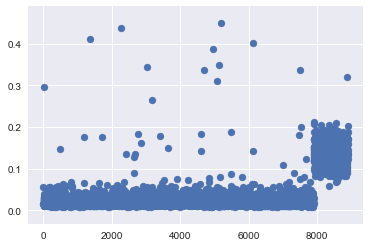

Current model: 
Layer dim :  94
Regularization param :  5e-06


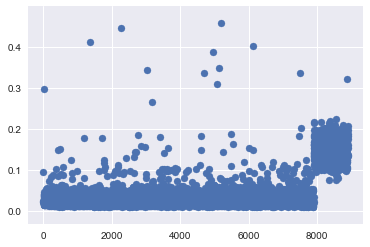

Current model: 
Layer dim :  23
Regularization param :  5e-06


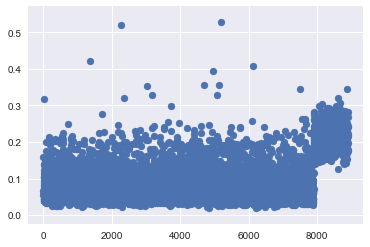

Current model: 
Layer dim :  11
Regularization param :  5e-06


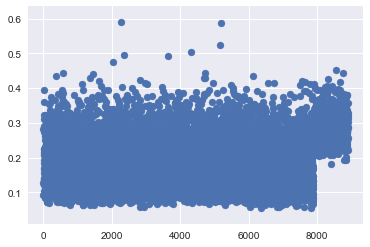

In [28]:
#Layer dim parameter :
List_of_parameters=[4*default_layer_dim,2*default_layer_dim,int(1.0*default_layer_dim/2),int(1.0*default_layer_dim/4)]
for param in List_of_parameters:
    model=Build_generic_model(param)
    model.fit(input_ae,output_ae,epochs=10,batch_size=128,verbose=0)
    Plot_model_error(X_test_norm,model)



In [29]:
# Conclude and define

optimal_layer_dim=4*default_layer_dim


# What is the best way to tune the regularization parameter ? 

First idea: Increase it (*10, *100)?  
Second idea : Reduce it  (/10, /100) ? 

Hint : Play with regularization_parameter

Current model: 
Layer dim :  188
Regularization param :  0.0005


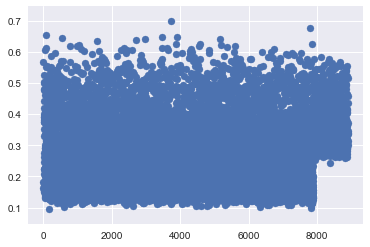

Current model: 
Layer dim :  188
Regularization param :  5e-05


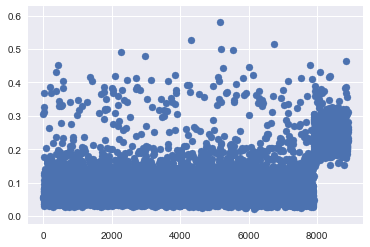

Current model: 
Layer dim :  188
Regularization param :  5.000000000000001e-07


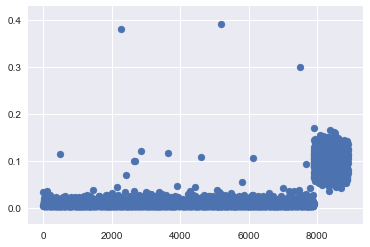

Current model: 
Layer dim :  188
Regularization param :  5.0000000000000004e-08


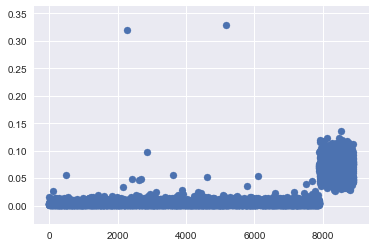

In [30]:
#First drop out parameter :
List_of_parameters=[default_reg*100,default_reg*10,default_reg/10,default_reg/100]
for param in List_of_parameters:
    model=Build_generic_model(optimal_layer_dim,param)
    model.fit(input_ae,output_ae,epochs=10,batch_size=128,verbose=0)
    Plot_model_error(X_test_norm,model)


In [31]:
# Conclude and define:

Optimal_regularization_parameter=default_reg/100

# Dropout

A dropout is another regularization technique, widely used with neural networks.
The principle is the following is the following, given a layer L and a probability p.
During the training, each node i of the layer L will have a probability p to "dropped out". 

This means that each of the node of the layer could be turned off with a probability p. 
In the generic model, we added two drop out layers.

The first one is right after the input and will randomly turn the input to 0.
The second one is after the first hidden layer. It will randomly turn off the features found by the autoencoder.
The parameter you can tune is the probability for each node to be dropped out (between 0 and 1) 

Objective : 
1)Play with the first dropout parameter 

2)Play with the second dropout parameter

Current model: 
Layer dim :  188
Regularization param :  5.0000000000000004e-08
First dropout param :  0.001


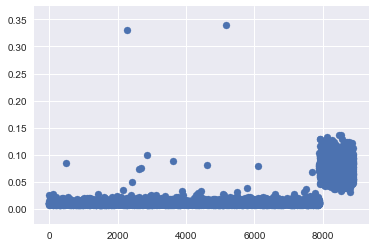

Current model: 
Layer dim :  188
Regularization param :  5.0000000000000004e-08
First dropout param :  0.005


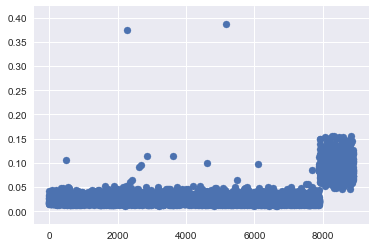

Current model: 
Layer dim :  188
Regularization param :  5.0000000000000004e-08
First dropout param :  0.01


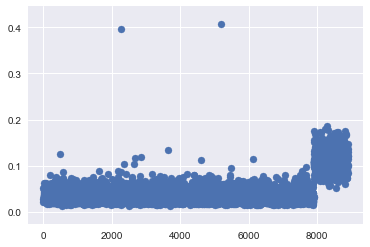

Current model: 
Layer dim :  188
Regularization param :  5.0000000000000004e-08
First dropout param :  0.05


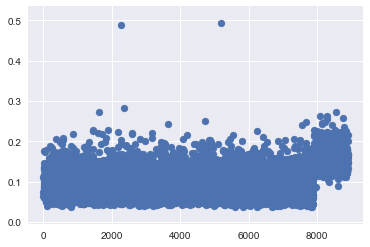

Current model: 
Layer dim :  188
Regularization param :  5.0000000000000004e-08
First dropout param :  0.1


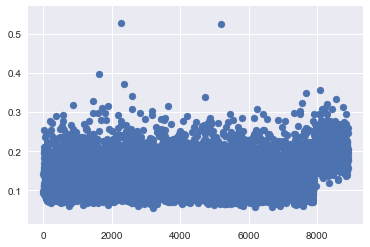

In [35]:
#First drop out parameter :
List_of_parameters=[0.001,0.005,0.01,0.05,0.1]
for param in List_of_parameters:
    model=Build_generic_model(optimal_layer_dim,Optimal_regularization_parameter,param)
    model.fit(input_ae,output_ae,epochs=10,batch_size=128,verbose=0)
    Plot_model_error(X_test_norm,model)



In [36]:
# Conclude and define 

optimal_first_dropout=0

Current model: 
Layer dim :  188
Regularization param :  5.0000000000000004e-08
Second dropout param :  0.1


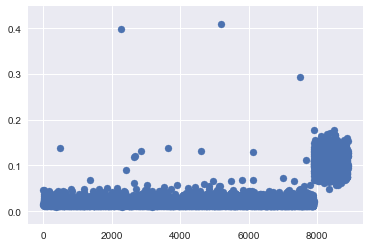

Current model: 
Layer dim :  188
Regularization param :  5.0000000000000004e-08
Second dropout param :  0.2


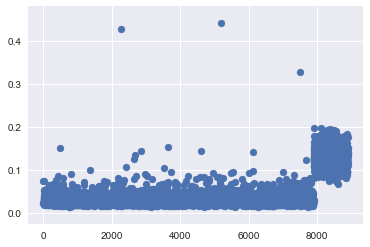

Current model: 
Layer dim :  188
Regularization param :  5.0000000000000004e-08
Second dropout param :  0.5


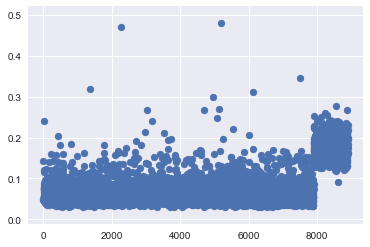

Current model: 
Layer dim :  188
Regularization param :  5.0000000000000004e-08
Second dropout param :  0.7


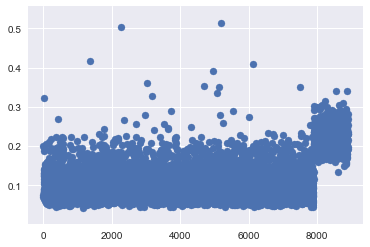

In [37]:
#second drop out parameter :
List_of_parameters=[0.1,0.2,0.5,0.7]
for param in List_of_parameters:
    model=Build_generic_model(optimal_layer_dim,Optimal_regularization_parameter,optimal_first_dropout,param)
    model.fit(input_ae,output_ae,epochs=10,batch_size=128,verbose=0)
    Plot_model_error(X_test_norm,model)



In [ ]:
#Observe and conclude 
optimal_second_dropout=0